In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from keras import datasets
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + "/../")

from bfcnn import BFCNN, collage

In [2]:
# setup environment
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
# get dataset 
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype(np.float32)
x_train = np.expand_dims(x_train, axis=3)
x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, axis=3)

In [4]:
EPOCHS = 100
FILTERS = 32
NO_LAYERS = 5
MIN_STD = 1.0
MAX_STD = 100.0
LR_DECAY = 0.95
LR_INITIAL = 0.1
BATCH_SIZE = 64
CLIP_NORMAL = 1.0
INPUT_SHAPE = (28, 28, 1)
PRINT_EVERY_N_BATCHES = 1000

In [5]:
# build model
model = \
    BFCNN(
        input_dims=INPUT_SHAPE,
        no_layers=NO_LAYERS,
        filters=FILTERS)

In [6]:
# train dataset
trained_model, history = \
    BFCNN.train(
        model=model, 
        input_dims=INPUT_SHAPE,
        dataset=x_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        min_noise_std=MIN_STD,
        max_noise_std=MAX_STD,
        lr_initial=LR_INITIAL,
        lr_decay=LR_DECAY,
        print_every_n_batches=PRINT_EVERY_N_BATCHES)


2021-03-29 17:50:24,611 INFO custom_callbacks.py:__init__:51] deleting existing training image in ./training/images
2021-03-29 17:50:24,614 INFO model.py:train:312] begin training


Epoch 1/100


/home/arxwn/Repositories/blind_image_denoising/venv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


938/938 [==============================] - 27s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 14.8681 - mae_loss: 9.2696
Epoch 2/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 6.7631 - mae_loss: 5.2314
Epoch 3/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 5.8311 - mae_loss: 4.7362
Epoch 4/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 5.3870 - mae_loss: 4.4764
Epoch 5/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 5.1666 - mae_loss: 4.3554
Epoch 6/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 4.9057 - mae_loss: 4.1408
Epoch 7/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 4.8534 - mae_loss: 4.1376
Epoch 8/100
938/938 [==============================]

938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.6378 - mae_loss: 3.2290
Epoch 61/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.7715 - mae_loss: 3.3668
Epoch 62/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.8881 - mae_loss: 3.4861
Epoch 63/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.7785 - mae_loss: 3.3753
Epoch 64/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.5775 - mae_loss: 3.1710
Epoch 65/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.5867 - mae_loss: 3.1833
Epoch 66/100
938/938 [==============================] - 23s 24ms/step - batch: 468.5000 - size: 63.9659 - loss: 3.6225 - mae_loss: 3.2187
Epoch 67/100
938/938 [=========================

2021-03-29 18:28:40,118 INFO model.py:train:332] finished  training


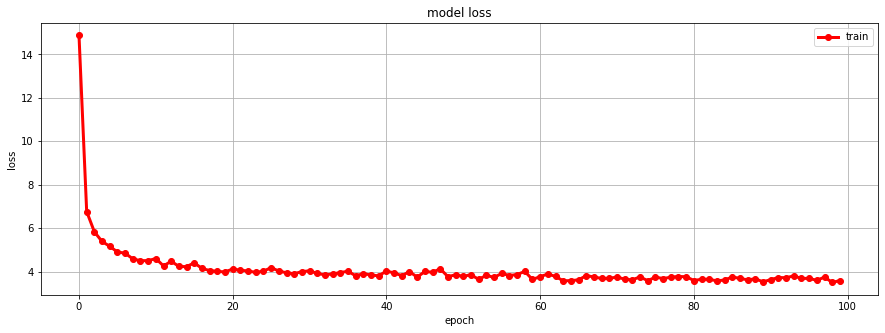

In [7]:
# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history["loss"],
         marker="o",
         color="red", 
         linewidth=3, 
         markersize=6)
plt.grid(True)
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc="upper right")
plt.show()

In [8]:
from math import log10

# calculate mse for different std
sample_test = x_test[0:1024,:,:,:]
sample_test_mse = []
sample_train = x_train[0:1024,:,:,:]
sample_train_mse = []
sample_std = []

for std_int in range(0, int(MAX_STD), 5):
    std = float(std_int)
    #
    noisy_sample_test = sample_test + np.random.normal(0.0, std, sample_test.shape)
    noisy_sample_test = np.clip(noisy_sample_test, 0.0, 255.0)
    results_test = trained_model.model.predict(noisy_sample_test)
    mse_test = np.mean(np.power(sample_test - results_test, 2.0))
    sample_test_mse.append(mse_test)
    #
    noisy_sample_train = sample_train + np.random.normal(0.0, std, sample_train.shape)
    noisy_sample_train = np.clip(noisy_sample_train, 0.0, 255.0)
    results_train = trained_model.model.predict(noisy_sample_train)
    mse_train = np.mean(np.power(sample_train - results_train, 2.0))
    sample_train_mse.append(mse_train)
    #
    sample_std.append(std)

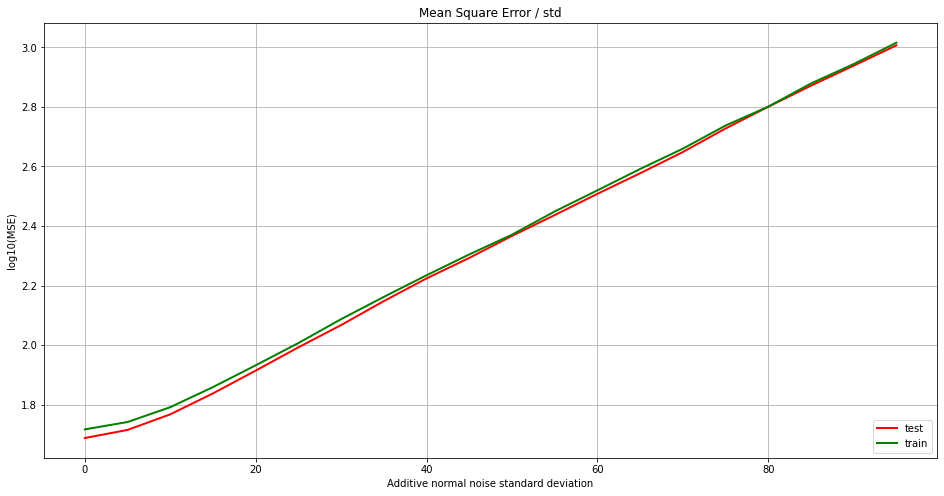

In [9]:
# summarize history for loss
plt.figure(figsize=(16,8))
plt.plot(sample_std,
         [log10(m) for m in sample_test_mse],
         color="red",
         linewidth=2)
plt.plot(sample_std,
         [log10(m) for m in sample_train_mse],
         color="green", 
         linewidth=2)
plt.grid(True)
plt.title("Mean Square Error / std")
plt.ylabel("log10(MSE)")
plt.xlabel("Additive normal noise standard deviation")
plt.legend(["test", "train"], loc="lower right")
plt.show()

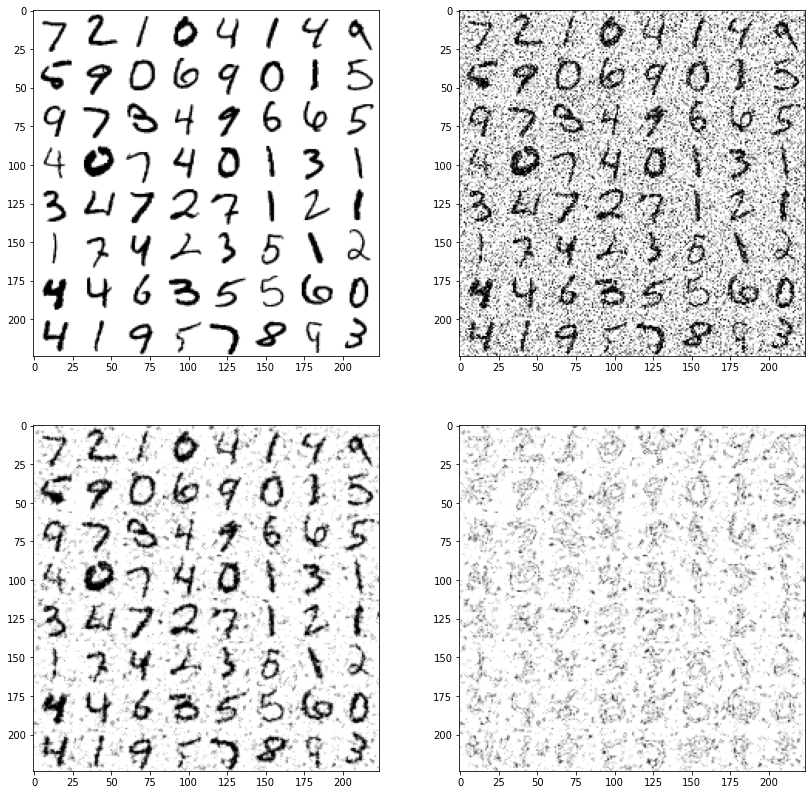

In [10]:
# draw test samples, predictions and diff
sample = x_test[0:64,:,:,:]
noisy_sample = sample + np.random.normal(0.0, 100.0, sample.shape)
noisy_sample = np.clip(noisy_sample, 0.0, 255.0)
results = trained_model.model.predict(noisy_sample)
    
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
plt.imshow(collage(sample), cmap="gray_r") 
plt.subplot(2, 2, 2)
plt.imshow(collage(noisy_sample), cmap="gray_r") 
plt.subplot(2, 2, 3)
plt.imshow(collage(results), cmap="gray_r") 
plt.subplot(2, 2, 4)
plt.imshow(collage(np.abs(sample - results)), cmap="gray_r") 
plt.show() 

In [11]:
trained_model.save("./model.h5")